In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
from density_db import density_database
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from tensorflow import keras
from tensorflow.keras import optimizers
import warnings

In [2]:
#get data
def get_data():
    rawData = density_database('density.db').selectAllErrorsWithParams('Redfield').fetchall()
    return pd.DataFrame(data=rawData, columns=['delta_e', 'J', 'lambda', 'gamma', 'T', 'error'])

In [3]:
#plot
def plot_error(data):
    data.loc[
        (data['delta_e'] == 100.)
        & (data['J'] == 100.)
        & (data['lambda'] == 100.)
        & (data['gamma'] == 100.)
        & (data['T'] == 300.)
    ].plot(kind="scatter", x="delta_e", y="error", logy=True)
    plt.ylim(10**-4,10**-2)

In [4]:
#explore combinations
def correletions():
    tryData = data.copy()
    tryData['gamma-lambda'] = tryData['gamma']*tryData['lambda']
    tryData['gamma-delta_e'] = tryData['gamma']*tryData['delta_e']
    tryData['gamma-J'] = tryData['gamma']*tryData['J']
    tryData['lambda-delta_e'] = tryData['lambda']*tryData['delta_e']
    tryData['lambda-J'] = tryData['lambda']*tryData['J']
    tryData['delta_e-J'] = tryData['delta_e']*tryData['J']
    corr_matrix = tryData.corr()
    corr_matrix

In [59]:
def prepare_train_and_test_sets(data):
    modifiedData = data.copy()
    modifiedData['delta_e'] = modifiedData['delta_e']/400
    modifiedData['J'] = modifiedData['J']/400
    modifiedData['lambda'] = modifiedData['lambda']/400
    modifiedData['gamma'] = modifiedData['gamma']/400
    modifiedData['T'] = modifiedData['T']/300
    modifiedData['gamma-lambda'] = modifiedData['gamma']*modifiedData['lambda']
    modifiedData['gamma-delta_e'] = modifiedData['gamma']*modifiedData['delta_e']
    modifiedData['gamma-J'] = modifiedData['gamma']*modifiedData['J']
    modifiedData['lambda-delta_e'] = modifiedData['lambda']*modifiedData['delta_e']
    modifiedData['lambda-J'] = modifiedData['lambda']*modifiedData['J']
    modifiedData['delta_e-J'] = modifiedData['delta_e']*modifiedData['J']
    #return train_test_split(modifiedData, test_size=0.2, random_state=42)
    return modifiedData

In [62]:
train_set = prepare_train_and_test_sets(get_data())
part_set = None
#part_set = train_set[train_set['lambda'] < 0.1]
#train_set = train_set.drop(part_set.index)
#train_set

In [7]:
def mspe(y, y_predicted):
    return 100 * np.sum(np.square((y - y_predicted)/y)) / len(y)

def mape(y, y_predicted):
    return 100 * np.sum(np.abs((y - y_predicted)/y)) / len(y)

def plot_sorted_labels(data_labels, labels_predicted):
    sort = np.argsort(data_labels)
    plt.plot(range(len(data_labels)), [data_labels[i] for i in sort])
    plt.plot(range(len(labels_predicted)), [labels_predicted[i] for i in sort])
    #plt.yscale('log')
    plt.ylim(10**-4, 10**-2)
    plt.show()
            
def trainMethod(method, train_set):
    data_labels = np.array(train_set["error"].copy())
    data_prepared = np.array(train_set.drop("error", axis=1))
    kfold = KFold(n_splits=10, shuffle=True, random_state=47)
    errors = [];
    errors_train = [];
    part_error = None;
    for train, test in kfold.split(data_prepared, data_labels):
        method.fit(data_prepared[train], data_labels[train])
        labels_predicted = method.predict(data_prepared[test])
        if len(errors) == 0:
            plot_sorted_labels(data_labels[test], labels_predicted)
        if len(errors) == 0 and part_set is not None:
            part_labels = np.array(part_set["error"].copy())
            part_prepared = np.array(part_set.drop("error", axis=1))
            part_error = mape(part_labels, method.predict(part_prepared))
        errors.append(mape(data_labels[test], labels_predicted))
        labels_predicted_train = method.predict(data_prepared[train])
        errors_train.append(mape(data_labels[train], labels_predicted_train))
    print('Test Error: %f%%' % (sum(errors)/len(errors)))
    print('Train Error: %f%%' % (sum(errors_train)/len(errors_train)))
    if part_error is not None:
        print('Part Error: %f%%' % (part_error))
    return errors

In [56]:
def trainNueralNetwork(train_set):
    train_set_nn = train_set.copy()
    data_labels = np.array(train_set_nn["error"].copy())
    data_prepared = np.array(train_set_nn.drop("error", axis=1))
    kfold = KFold(n_splits=2, shuffle=True, random_state=47)
    errors = [];
    errors_train = [];
    part_error = None;
    for train, test in kfold.split(data_prepared, data_labels):
        method = keras.Sequential([
            keras.layers.Dense(11, activation='linear', input_shape=(11,)),
            keras.layers.Dense(11, activation='tanh'),
            keras.layers.Dense(1)
        ])
        optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.9)
        method.compile(optimizer=optimizer, loss='mean_absolute_percentage_error')
        method.fit(data_prepared[train], data_labels[train], epochs=200, validation_split=0, verbose=0)
        labels_predicted = method.predict(data_prepared[test])
        if len(errors) == 0:
            plot_sorted_labels(data_labels[test], labels_predicted)
        if len(errors) == 0 and part_set is not None:
            part_labels = np.array(part_set["error"].copy())
            part_prepared = np.array(part_set.drop("error", axis=1))
            part_error = mape(part_labels, method.predict(part_prepared)[:,0])
        errors.append(mape(data_labels[test], labels_predicted[:,0]))
        labels_predicted_train = method.predict(data_prepared[train])
        errors_train.append(mape(data_labels[train], labels_predicted_train[:,0]))
        #print(errors)
        #break
    print('Test Error: %f%%' % (sum(errors)/len(errors)))
    print('Train Error: %f%%' % (sum(errors_train)/len(errors_train)))
    if part_error is not None:
        print('Part Error: %f%%' % (part_error))
    return errors

In [33]:
#linear su validation
def linear():
    lin_reg = LinearRegression()
    return trainMethod(lin_reg, train_set)
    
#forest su validation
def randomForestRegressor():
    for_reg = RandomForestRegressor(n_estimators=50)
    return trainMethod(for_reg, train_set)
    
#support vector machines
def support_vector_machines():
    warnings.filterwarnings('ignore')
    svr = SVR(kernel = 'poly', epsilon = 10**-4, tol=10**-4)
    res = trainMethod(svr, train_set)
    warnings.filterwarnings('always')
    return res
    
#k nearest
def k_nearest():
    eigh = KNeighborsRegressor(n_neighbors=5, weights='uniform')
    return trainMethod(eigh, train_set)
    
#linear lasso
def linear_lasso():
    lasso = Lasso()
    return trainMethod(lasso, train_set)

#linear ridge
def linear_ridge():
    ridge = Ridge()
    return trainMethod(ridge, train_set)

#decision tree
def decision_tree():
    decision = DecisionTreeRegressor()
    return trainMethod(decision, train_set)
    
#gaussian process
def gaussian_process():
    kernel = DotProduct() + WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0)
    return trainMethod(gpr, train_set)

linear


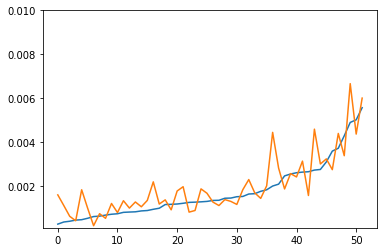

Test Error: 42.474566%
Train Error: 41.419707%

linear_lasso


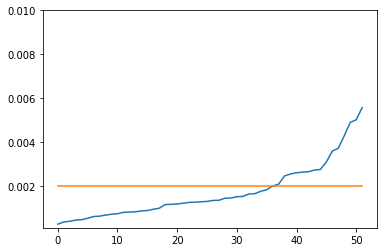

Test Error: 99.563581%
Train Error: 99.546342%

linear_ridge


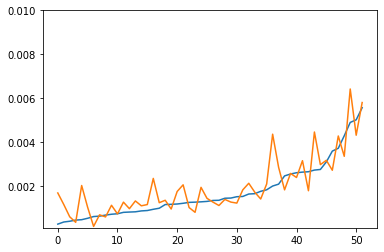

Test Error: 42.725134%
Train Error: 41.696424%

randomForestRegressor


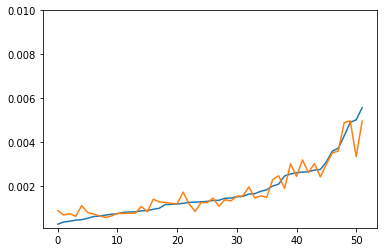

Test Error: 25.185673%
Train Error: 17.646902%

decision_tree


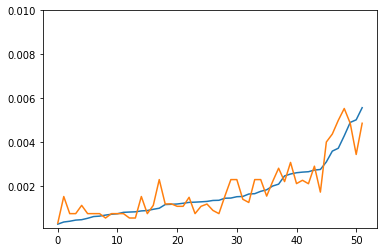

Test Error: 27.775633%
Train Error: 17.897839%

k_nearest


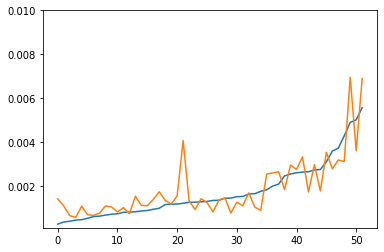

Test Error: 32.177788%
Train Error: 26.595040%

svm


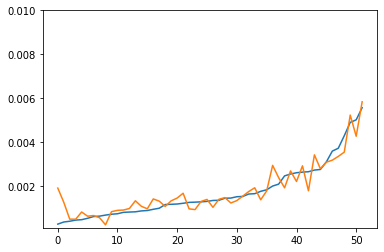

Test Error: 29.287780%
Train Error: 26.462006%

gaussian_process


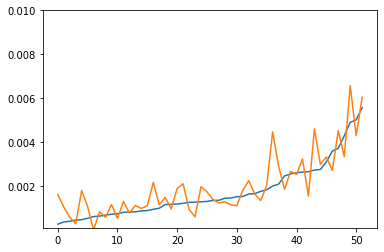

/home/edvardas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.44865167e-05, 2.04421773e+02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


Test Error: 43.025209%
Train Error: 41.901224%

neural network


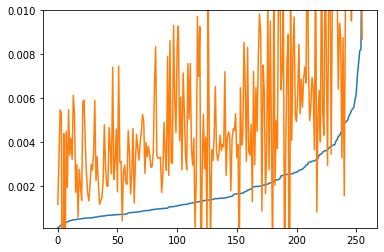

Test Error: 273.568518%
Train Error: 261.260351%


[325.55986743708854, 221.57716908919457]

In [63]:
print('linear')
linear()
print()
print('linear_lasso')
linear_lasso()
print()
print('linear_ridge')
linear_ridge()
print()
print('randomForestRegressor')
randomForestRegressor()
print()
print('decision_tree')
decision_tree()
print()
print('k_nearest')
k_nearest()
print()
print('svm')
support_vector_machines()
print()
print('gaussian_process')
gaussian_process()
print()
print('neural network')
trainNueralNetwork(train_set)